In [ ]:
import numpy as np
import h5py

f = h5py.File('./scatoneimage.mat','r')
imagen = np.array(f['image']).transpose()
joan_scat = np.array(f['feature'])

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt
plt.subplot(1,2,1)
plt.imshow(imagen)
print('[',np.min(imagen),',',np.max(imagen),']')
plt.subplot(1,2,2)
h=np.histogram(imagen[:],bins=np.linspace(0, 255, 100))
#plt.plot(h[0],h[1])
#plt.show()
h[0]

In [4]:
#extract exemplar data
import numpy as np
from skimage import data
from skimage.transform import resize
imagen = data.camera()
px=32
imagen = resize(imagen, (px, px))

In [5]:
import numpy as np
from scattering.scattering import scattering

px = 5
py = 4
aa = np.arange(0,3*px*py)
aa = aa.reshape((3,px,py))

S = scattering(aa,m=3)

px = min(px,py)
aa.shape
#print(aa[:,0:px,0:px])
#print('and nw:')
#print(aa)


/Users/ferradans/Documents/Research/ScatteringPython/scattering/scattering/scattering.py:80: UserWarning: Variable x has shape (3, 5, 4), which is not in format (N,px,px). We crop to the smallest dimension.
  warnings.warn(warning_string.format(x.shape))
/Users/ferradans/Documents/Research/ScatteringPython/scattering/scattering/scattering.py:88: UserWarning: No filter input, we create a Morlet filter bank with J= 2 and L=8
  warnings.warn(warning_string.format(J,L))
/Users/ferradans/Documents/Research/ScatteringPython/scattering/scattering/scattering.py:106: UserWarning: Parameter m out of bounds, valid values are 0,1,2 not 3
  warnings.warn(warning_string.format(m))


In [33]:
import warnings
m=3
J=2
L=3
num_coefs = {
    0: int(1),
    1: int(1+J*L),
    2: int(1+J*L+J*(J-1)*L**2/2)
}.get(m,-1) #[m](m)

if num_coefs == -1:
    warning_string = "Parameter m out of bounds, valid values are 0,1,2 not {0}"
    warnings.warn(warning_string.format(m))
    return
print(m)
print(num_coefs)
num_coefs

3
-1


/Users/ferradans/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: Parameter m out of bounds, valid values are 0,1,2 not 3


-1

In [7]:
from scattering.filter_bank import filter_bank_morlet2d, filterbank_to_multiresolutionfilterbank
from scattering.scattering import scattering
    
J=3
L=6

wavelet_filters, littlewood = filter_bank_morlet2d(px, J=J, L=L, sigma_phi=0.6957,sigma_xi=0.8506 )

Filters = filterbank_to_multiresolutionfilterbank(wavelet_filters,J)

S = scattering(imagen[np.newaxis,:,:], Filters,m=1)
myscat = S[0][0,:,:,:]
myscat.shape=(myscat.shape[0]*myscat.shape[1]*myscat.shape[2])

/Users/ferradans/Documents/Research/ScatteringPython/scattering/scattering/scattering.py:81: UserWarning: Variable x has shape (1, 48, 32), which is not in format (N,px,px). We crop to the smallest dimension.
  warnings.warn(warning_string.format(x.shape))


ValueError: operands could not be broadcast together with shapes (1,48,32) (32,32) 

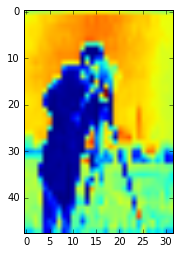

In [11]:
import matplotlib.pylab as plt
%matplotlib inline
im = resize(imagen, (48, 32))
plt.imshow(im)
S = scattering(im[np.newaxis,:,:], Filters,m=1)


In [ ]:
print(myscat.shape)
print(joan_scat.shape)

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt

plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.plot(myscat)
plt.axis([0,8128, 0, 150])
plt.subplot(1,2,2)
plt.plot(joan_scat)
plt.axis([0,8128, 0, 150])
plt.show()

In [ ]:
vj = joan_scat[0:64]
vm = myscat[0:64]
n = np.arange(0,64)
plt.figure(figsize=(18,8))
#plt.subplot(1,3,1)
plt.plot(n,vm,n,vj)
#plt.axis([0,64, 0, 150])
#plt.subplot(1,3,2)
#plt.plot(n,vj)
#plt.axis([0,64, 0, 150])
#plt.subplot(1,3,3)
#plt.plot(vj,vm,'*')
#plt.axis([0,300,0,300])

plt.show()

In [ ]:
plt.subplot(1,2,1)
plt.imshow(np.reshape(vj,(8,8)))
plt.subplot(1,2,2)
plt.imshow(np.reshape(vm,(8,8)))
plt.show()

In [ ]:
def apply_lowpass(img, phi, J, N_scat):
    # NB: I could compute N_scat here, but in case we want to oversample, this
    # may be useful. I should make a class.

    #This function can be applied to a set of images and angles, the input img is assumed
    #to be of size (num_images,L,size_x,size_y)

    N_nolp = img.shape[-1]

    N_nolp_r = N_nolp // 2 + 1
    dsf = N_nolp / N_scat

    # out will in the end point to a downsampled lowpassed image
    # out = ifft(fft(img, axis=1)
    #    * phi[0, :].reshape(1, N_nolp), axis=1)[:, ::dsf]

    # TO DO: use real transforms
    out = np.zeros((img.shape[:-1] + (N_nolp_r, 1)))
    out.shape = out.shape[:-1]
    # out = np.zeros((img.shape[0],img.shape[1], N_nolp_r))
    out[:] = np.fft.rfft(img, axis=-1) * phi[0, :N_nolp_r].reshape(1, N_nolp_r)

    out = np.fft.irfft(out, axis=-1)[..., ::dsf].copy()
    out = np.fft.rfft(out, axis=-2) * phi[:N_nolp_r, 0].reshape(N_nolp_r, 1)
    out = np.fft.irfft(out, axis=-2)[..., ::dsf, :]
    out = 2 ** (J - 1) * np.real(out)

    return out

In [ ]:
from scattering.scattering import apply_lowpass
#Zero order coeffs
spatial_coefs = 8
Scero= apply_lowpass(imagen, wavelet_filters['phi'][0], J,  spatial_coefs)

In [ ]:
np.linspace(0,32,9)

In [ ]:
f = h5py.File('./joanphi.mat','r')
joanphi = np.array(f['phi']).transpose()
plt.imshow(joanphi)
plt.colorbar()
plt.show()

In [ ]:
phimio=wavelet_filters['phi'][0]
plt.imshow(np.abs(phimio))
plt.colorbar()
plt.show()

In [ ]:
v = np.linspace(0,31,9).astype('int')
iv =imagen[v,:]
im = iv[:,v]

plt.subplot(1,2,1)
plt.imshow(im)
plt.show()